## stuff

In [13]:
from pymonntorch import *
import torch
from matplotlib import pyplot as plt
import math
import numpy as np
import random

In [14]:
random.seed(4255)  # Seed for Python's built-in random module
np.random.seed(4255)  # Seed for NumPy's random module

In [15]:
class TimeResolution(Behavior):
    def initialize(self, net):
        net.dt = self.parameter('dt', 1)
        net.t_passed = 0


In [16]:
class ConstantCurrent(Behavior):
    def initialize(self, ng):
        self.value = self.parameter('value', None)
    
    def forward(self, ng):
        ng.I = ng.vector(mode=self.value)

class NoiseCurrent(Behavior):
    def initialize(self,ng):
        self.value = self.parameter('value', None)
        self.limit = self.parameter('limit', 1)
        self.rate = self.parameter('rate', 0.5)
        ng.I = ng.vector(mode=self.value)
    
    def forward(self, ng):
        if(random.random() < self.rate):
            rnd = round(np.random.normal(0, 1)) * self.limit
            x = ng.I + rnd < 0
            if sum(x) == 0:
                ng.I += rnd
            else:
                ng.I -= rnd



In [ ]:
class TimeSpikeFirstCurrent(Behavior):
    def initialize(self, ng):
        self.value = self.parameter('value', None)
        self.T = self.parameter('T', 100)
        self.image = self.parameter('image', None)
        self.delay = (1.0 - self.image) * self.T

        ng.I = ng.vector(mode=0)
    
    def forward(self, ng):
        apply_cur = self.delay <= ng.network.iteration
        ng.I[apply_cur] = self.value
        if ng.network.iteration >= self.T:
            ng.I = ng.vector(mode=0)

class PositionCodingCurrent(Behavior):
    def initialize(self, ng):
        self.value = self.parameter('value', None)
        self.min_rate = self.parameter('min_rate', 0)
        self.max_rate = self.parameter('max_rate', 10)
        self.image = self.parameter('image', 10)
        self.T = self.parameter('T', 100)
        self.fr = self.min_rate + (self.max_rate - self.min_rate) * self.image
        
        ng.I = ng.vector(mode=0)
    
    def forward(self, ng):
        ng.I = self.fr/self.max_rate*self.value
        if ng.network.iteration >= self.T:
            ng.I = ng.vector(mode=0)

class PoissonDistCurrent(Behavior):
    def initialize(self, ng):
        self.threshold = self.parameter('threshold', -40)
        #self.pattern = self.parameter('pattern', None)
        self.image = self.parameter('image', None)
        self.max_rate = self.parameter('max_rate', 100)
        self.min_rate = self.parameter('min_rate', 0)
        self.max_rate = self.parameter('max_rate', 10)
        self.T = self.parameter('T', 75)
        
        fr = self.min_rate + (self.max_rate - self.min_rate) * self.image

        # if self.pattern == 'A':
        # else:
        #     fr = self.min_rate + (self.max_rate - self.min_rate) * (1.0 - self.image)
        
        self.spike_times_list = torch.zeros(self.T, ng.size, dtype=torch.bool)
        for n, rate in enumerate(fr):
            num_spikes = np.random.poisson(rate * self.T)
            # Spike times are uniformly distributed over the duration
            spike_times = np.random.randint(0, self.T, num_spikes)
            for times in spike_times:
                self.spike_times_list[times][n] = True

    def forward(self, ng):
        if ng.network.iteration < self.T:
            ng.u[self.spike_times_list[ng.network.iteration]] = self.threshold


In [17]:
def drawPlots(net, ng, rec, event):
    fig, axs = plt.subplots(3, figsize=(15, 15))

    axs[0].plot(net[rec, 0].variables['I'][:,:1])
    axs[0].set_ylabel("I(t)")

    # mean_u_per_it = torch.mean(net[rec, 0].variables['u'], dim=1)
    # axs[1].plot(mean_u_per_it)
    # axs[1].set_ylabel("Avg u(t)")

    unique_times, counts= torch.unique(net[event, 0].variables['spike'][:, 0], sorted=True, return_counts=True)
    axs[1].plot(unique_times, counts/ng.size)
    axs[1].set_ylabel("A(t)")
    
    axs[2].scatter(net[event, 0].variables['spike'][:, 0], net[event, 0].variables['spike'][:, 1])
    axs[2].set_xlabel("time")
    axs[2].set_ylabel("spikes")
    
    plt.show()

In [18]:
class LIF(Behavior):
    def initialize(self, ng):
        self.R = self.parameter('R', 1)
        self.tau = self.parameter('tau', 10)
        self.threshold = self.parameter('threshold', -50)
        self.u_rest = self.parameter('u_rest', -67)
        self.u_reset = self.parameter('u_reset', -72)

        ng.u = ng.vector('normal(0.3,0.05)')
        ng.u += self.u_reset

        ng.spike = ng.u >= self.threshold
        ng.u[ng.spike] = self.u_reset

    def forward(self, ng):
        #dynamic
        leakage = -(ng.u - self.u_rest)
        current = self.R * ng.I 
        ng.u += (leakage + current) * ng.network.dt / self.tau 
        
        #fire and reset 
        ng.spike = ng.u >= self.threshold
        ng.u[ng.spike] = self.u_reset

In [19]:
class SynFunc(Behavior):
    def initialize(self, syn):
        self.coef = self.parameter('coef', None)
        self.mu = self.parameter('mu', 1)
        self.sigma = self.parameter('sigma', 0.1)
        self.W = syn.matrix(f'normal({self.mu}, {self.sigma})')
    
    def forward(self, syn):
        pre_spike = syn.src.spike
        syn.I = torch.sum(self.W[pre_spike], axis=0) * self.coef

class SynFuncFull(Behavior):
    def initialize(self, syn):
        self.coef = self.parameter('coef', None)
        self.mu = self.parameter('mu', 0)
        self.sigma = self.parameter('sigma', 10)
        self.N = self.parameter('N', 100)
        self.W = syn.matrix(f'normal({self.mu/self.N}, {self.sigma/math.sqrt(self.N)})')
        #self.W = syn.matrix(mode=self.mu/self.N)
    
    def forward(self, syn):
        pre_spike = syn.src.spike
        syn.I = torch.sum(self.W[pre_spike], axis=0) * self.coef

class SynFuncRandFCP(Behavior):
    def initialize(self, syn):
        self.J = self.parameter('J', 1)
        self.p = self.parameter('p', 0.1)
        self.N = self.parameter('N', 100)
        self.W = syn.matrix(mode = self.J/(self.N*self.p))
        self.coef = self.parameter('coef', None)

        mask = torch.bernoulli(torch.full(self.W.shape, self.p)).to(self.W.device)
        self.W *= mask
    
    def forward(self, syn):
        pre_spike = syn.src.spike
        syn.I = torch.sum(self.W[pre_spike], axis=0) * self.coef

class SynFuncRandFNPP(Behavior):
    def initialize(self, syn):
        self.C = self.parameter('C', None)
        self.coef = self.parameter('coef', None)
        self.mu = self.parameter('mu', 1)
        self.sigma = self.parameter('sigma', 0.1)
        self.W = syn.matrix(f'normal({self.mu}, {self.sigma})')

        for i in range(len(self.W[0])):
            mask = torch.randperm(len(self.W))
            mask = mask[:len(self.W)-self.C]
            for x in mask:
                self.W[x][i] = 0.0
        #print(list(self.W))
    def forward(self, syn):
        pre_spike = syn.src.spike

        syn.I = torch.sum(self.W[pre_spike], axis=0) * self.coef

class SynFuncFNPP(Behavior):
    def initialize(self, syn):
        self.C = self.parameter('C', None)
        self.coef = self.parameter('coef', None)
        self.W = syn.get_random_synapse_mat_fixed(self.C)
    
    def forward(self, syn):
        pre_spike = syn.src.spike
        syn.I = torch.sum(self.W[pre_spike], axis=0) * self.coef


class inputForwardConduc(Behavior):
    def initialize(self, syn):
        self.g_max = self.parameter('g_max', None)
        self.tau_syn = self.parameter('tau_syn', None)
    
    def forward(self, syn):
        pass
        # print(syn.src.network['ng1_eventrec', 0].variables['spike'][:, 0])
        # pre_spike = syn.src['spike', 0][:, 0]
        
        # tm = syn.src.network.dt * syn.src.network.iteration 
        # syn.g = torch.sum(torch.where(tm > pre_spike, self.g_max * torch.exp(-(tm - pre_spike) / self.tau_syn)), axis = 0)

In [20]:
class DendriteDirac(Behavior):
    def forward(self, ng):
        for synapse in ng.afferent_synapses["All"]:
            ng.I += synapse.I

        # for synapse in ng.afferent_synapses["inh"]:
        #     ng.I -= synapse.I

class DendriteConduc(Behavior):
    def initialize(self, ng):
        self.E = self.parameter('E', None)
    
    def forward(self, ng):
        for synapse in ng.afferent_synapses["All"]:
            ng.I += synapse.g + ng.u - self.E

## connectivity schemes pure exc


Network['Network'](Neurons: tensor(400)|1 groups, Synapses: tensor(160000)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](400){2:NoiseCurrent(value=6,limit=0.1,rate=1,)4:DendriteDirac()5:LIF(R=5,threshold=-50,u_rest=-70,u_reset=-70,tau=10,)7:Recorder(variables=['u', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)8:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_eventrec,)}
SynapseGroup['exc', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S400xD400){3:SynFuncFull(N=400,mu=0.2,sigma=0.1,coef=1,),}
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([4

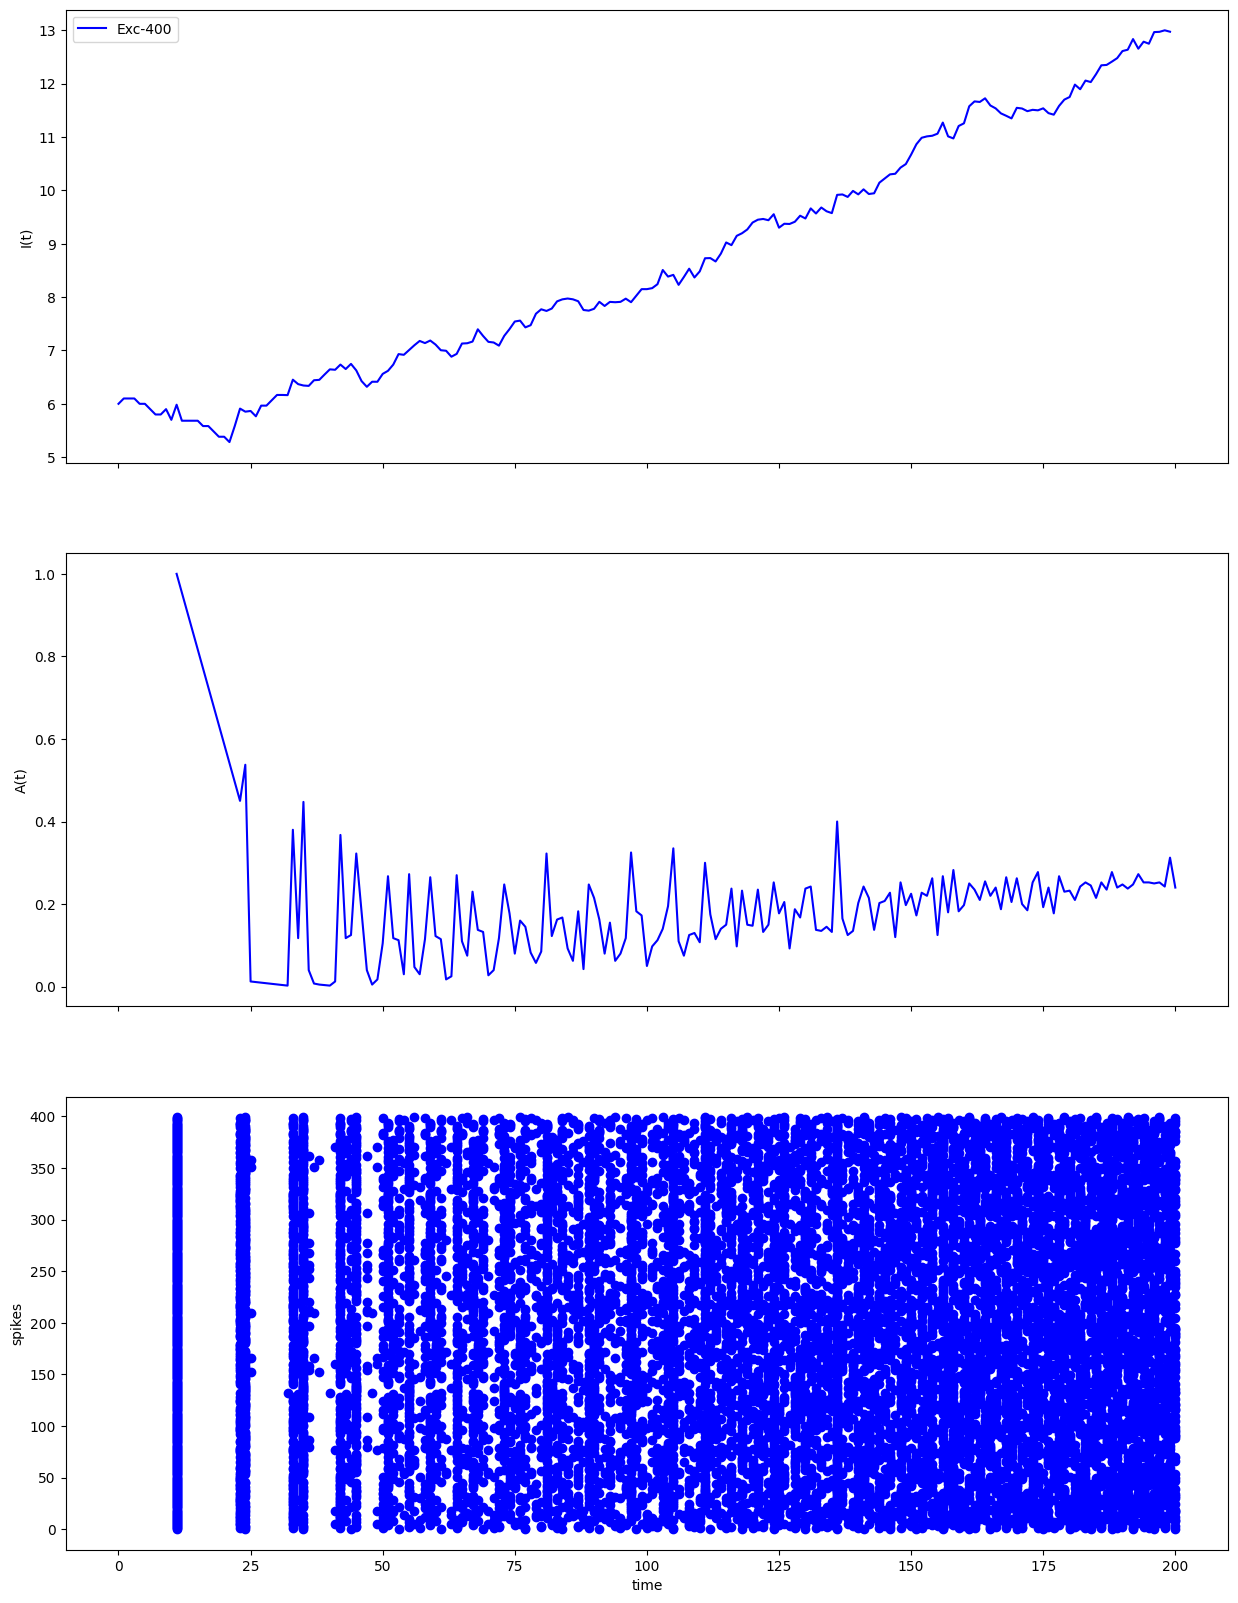

In [21]:
N = 400
p = 1
net = Network(behavior={1: TimeResolution(dt=1)})
ng1 = NeuronGroup(net=net,
                  size=round(N*p),
                  behavior={2: NoiseCurrent(value=6, limit=0.1, rate=1),
                            4: DendriteDirac(),
                            5: LIF(R=5, 
                                        threshold=-50, 
                                        u_rest=-70, 
                                        u_reset=-70,  
                                        tau=10), 
                            7: Recorder(tag='ng1_rec', variables=['u', 'I']), 
                            8: EventRecorder(tag='ng1_eventrec', variables=['spike'])})

#SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFunc(mu=0.001, sigma=0.001, coef=1)})

SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFuncFull(N=N, mu=0.2, sigma=0.1, coef=1)})

# SynapseGroup(tag='exc',net=net, src=ng1, dst=ng1, behavior={3: SynFuncRandFCP(N=N, p=0.1, J=0.5, coef=1)})

# SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFuncRandFNPP(C=150, mu=0.01, sigma=0.01, coef=1)})


net.initialize()
#net.simulate_iterations(200)
net.simulate_iterations(200)

fig, axs = plt.subplots(3, sharex=True, figsize=(15, 20))
axs[0].plot(net['ng1_rec', 0].variables['I'][:,:1], color='blue', label=f'Exc-{ng1.size}')
axs[0].set_ylabel("I(t)")
axs[0].legend()

unique_times1, counts1= torch.unique(net['ng1_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
axs[1].plot(unique_times1, counts1/ng1.size, color='blue')
axs[1].set_ylabel("A(t)")

axs[2].scatter(net['ng1_eventrec', 0].variables['spike'][:, 0], net['ng1_eventrec', 0].variables['spike'][:, 1], color='blue')
axs[2].set_xlabel("time")
axs[2].set_ylabel("spikes")

plt.show()

## connection schemes inhib


Network['Network'](Neurons: tensor(100)|2 groups, Synapses: tensor(3200)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](80){2:NoiseCurrent(value=5,limit=0.5,rate=1,)4:DendriteDirac()5:LIF(R=5,threshold=-60,u_rest=-70,u_reset=-70,tau=10,)7:Recorder(variables=['u', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)8:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_eventrec,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](20){2:NoiseCurrent(value=0,limit=0.5,rate=1,)4:DendriteDirac()5:LIF(R=5,threshold=-60,u_rest=-70,u_reset=-70,tau=10,)7:Recorder(variables=['u', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)8:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_eventrec,)}
SynapseGroup['exc', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_2'](S80xD20){3:SynFuncFull(N=100,mu=0.2,sigma=0.1,coef=1,),}
SynapseGroup['inh', 'SynapseGroup'

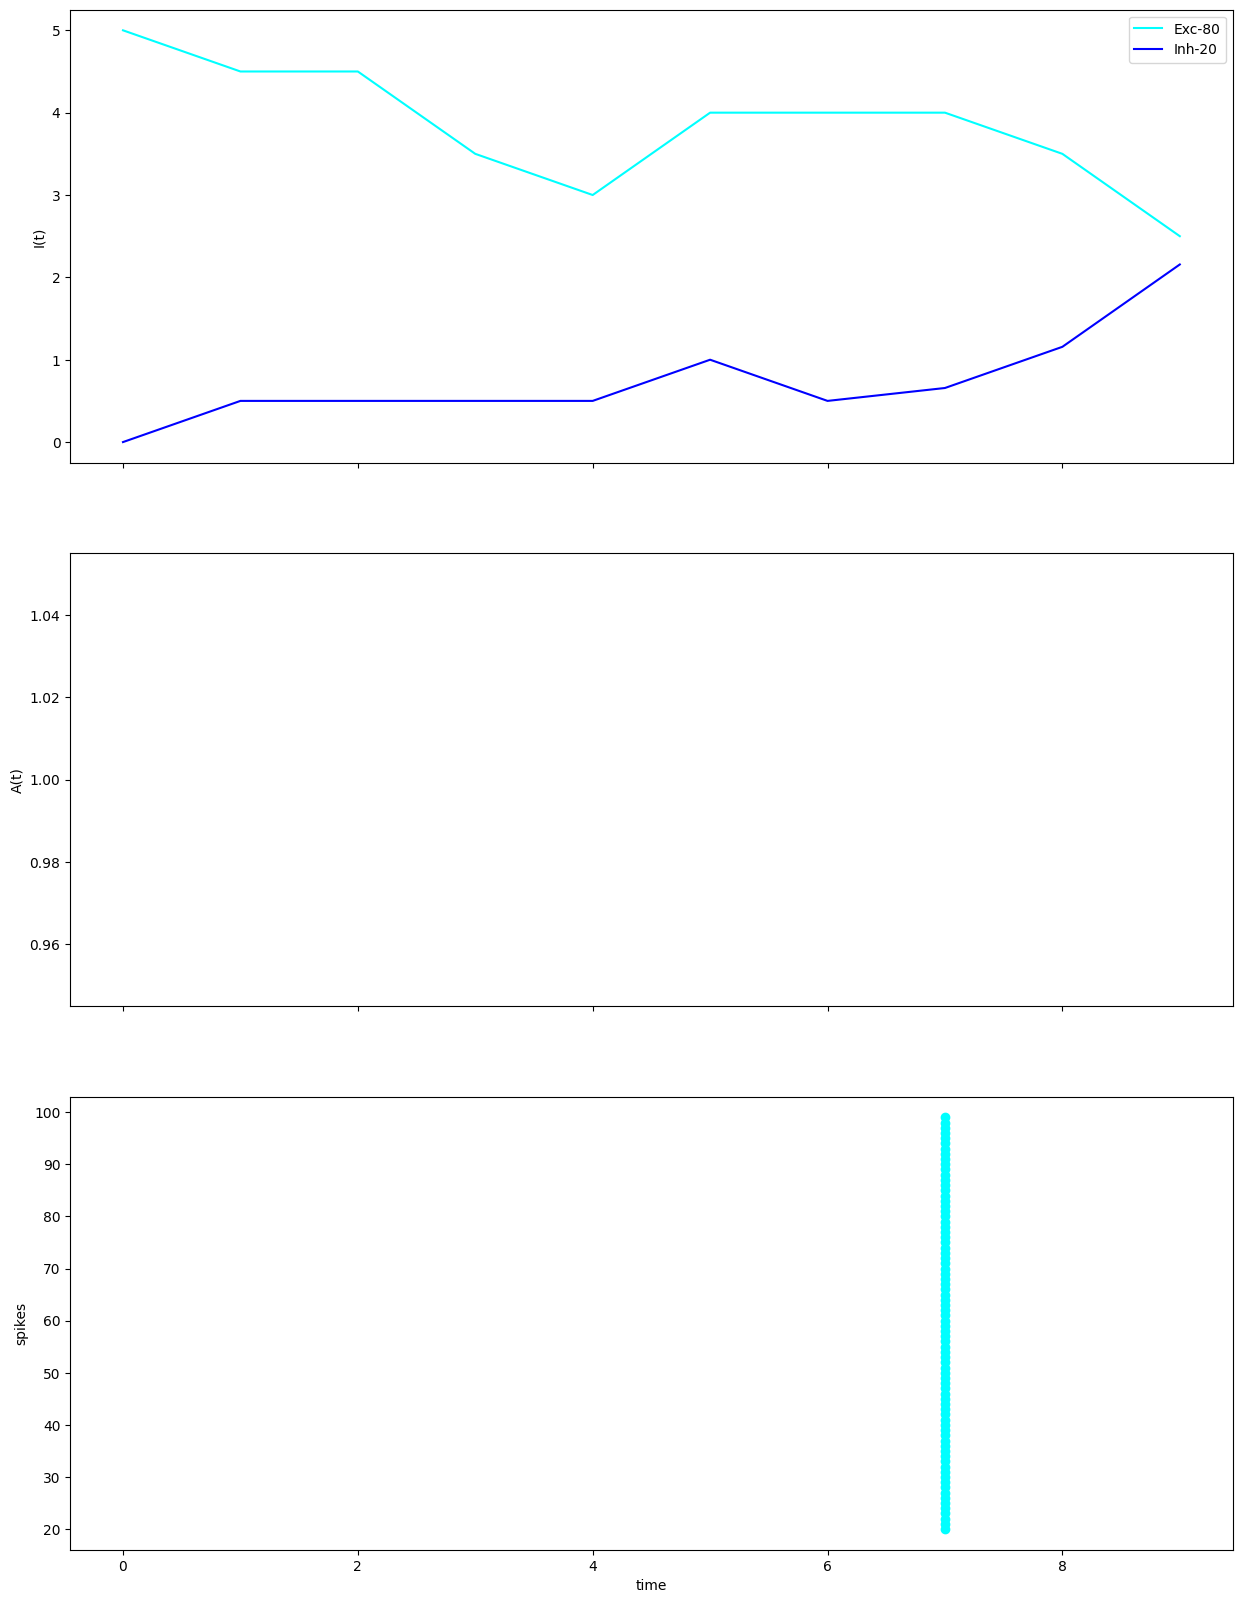

In [22]:
N = 100
M = 400
p = 0.8
net = Network(behavior={1: TimeResolution(dt=1)})
ng1 = NeuronGroup(net=net,
                  size=round(N*p),
                  behavior={2: NoiseCurrent(value=5, limit=0.5, rate=1), 
                            4: DendriteDirac(),
                            5: LIF(R=5, 
                                        threshold=-60, 
                                        u_rest=-70, 
                                        u_reset=-70,  
                                        tau=10), 
                            7: Recorder(tag='ng1_rec', variables=['u', 'I']), 
                            8: EventRecorder(tag='ng1_eventrec', variables=['spike'])})

ng2 = NeuronGroup(net=net,
                  size=round(N*(1-p)),
                  behavior={2: NoiseCurrent(value=0, limit=0.5, rate=1), 
                            4: DendriteDirac(),
                            5: LIF(R=5, 
                                        threshold=-60, 
                                        u_rest=-70, 
                                        u_reset=-70,  
                                        tau=10), 
                            7: Recorder(tag='ng2_rec', variables=['u', 'I']), 
                            8: EventRecorder(tag='ng2_eventrec', variables=['spike'])})

# ng3 = NeuronGroup(net=net,
#                   size=round(M*p),
#                   behavior={2: NoiseCurrent(value=5, limit=0.5, rate=1), 
#                             4: DendriteDirac(),
#                             5: LIF(R=5, 
#                                         threshold=-60, 
#                                         u_rest=-70, 
#                                         u_reset=-70,  
#                                         tau=10), 
#                             7: Recorder(tag='ng3_rec', variables=['u', 'I']), 
#                             8: EventRecorder(tag='ng3_eventrec', variables=['spike'])})

# ng4 = NeuronGroup(net=net,
#                   size=round(M*(1-p)),
#                   behavior={2: NoiseCurrent(value=0, limit=0.5, rate=1), 
#                             4: DendriteDirac(),
#                             5: LIF(R=5, 
#                                         threshold=-35, 
#                                         u_rest=-70, 
#                                         u_reset=-70,  
#                                         tau=10), 
#                             7: Recorder(tag='ng4_rec', variables=['u', 'I']), 
#                             8: EventRecorder(tag='ng4_eventrec', variables=['spike'])})

# SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFunc(mu=0.01, sigma=0.1, coef=1)})
# SynapseGroup(tag='inh',net=net, src=ng2, dst=ng1, behavior={3: SynFunc(mu=0.01, sigma=0.1, coef=-1)})
# SynapseGroup(tag='exc', net=net, src=ng3, dst=ng4, behavior={3: SynFunc(mu=0.01, sigma=0.1, coef=1)})
# SynapseGroup(tag='inh',net=net, src=ng4, dst=ng3, behavior={3: SynFunc(mu=0.01, sigma=0.1, coef=-1)})

SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncFull(N=N, mu=0.2, sigma=0.1, coef=1)})
SynapseGroup(tag='inh',net=net, src=ng2, dst=ng1, behavior={3: SynFuncFull(N=N, mu=0.2, sigma=0.1, coef=-1)})
# SynapseGroup(tag='exc', net=net, src=ng3, dst=ng4, behavior={3: SynFuncFull(N=M, mu=0.2, sigma=0.1, coef=1)})
# SynapseGroup(tag='inh',net=net, src=ng4, dst=ng3, behavior={3: SynFuncFull(N=M, mu=0.2, sigma=0.1, coef=-1)})

# SynapseGroup(tag='exc',net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFCP(N=ng1.size, p=0.1, J=0.1, coef=1)})
# SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFCP(N=ng2.size,  p=0.1, J=0.1, coef=-1)})
# SynapseGroup(tag='exc',net=net, src=ng3, dst=ng3, behavior={3: SynFuncRandFCP(N=ng3.size, p=0.1, J=0.1, coef=1)})
# SynapseGroup(tag='inh', net=net, src=ng4, dst=ng4, behavior={3: SynFuncRandFCP(N=ng4.size,  p=0.1, J=0.1, coef=-1)})

# SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFNPP(N=ng1.size, C=5, mu=0.01, sigma=0.1, coef=1)})
# SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFNPP(N=ng2.size, C=5, mu=0.01, sigma=0.1, coef=-1)})
# SynapseGroup(tag='exc', net=net, src=ng3, dst=ng4, behavior={3: SynFuncRandFNPP(N=ng3.size, C=5, mu=0.01, sigma=0.1, coef=1)})
# SynapseGroup(tag='inh', net=net, src=ng4, dst=ng3, behavior={3: SynFuncRandFNPP(N=ng4.size, C=5, mu=0.01, sigma=0.1, coef=-1)})


net.initialize()
#net.simulate_iterations(200)
net.simulate_iterations(10)

fig, axs = plt.subplots(3, sharex=True, figsize=(15, 20))
random.seed(42)  # Seed for Python's built-in random module
np.random.seed(42)  # Seed for NumPy's random module
axs[0].plot(net['ng1_rec', 0].variables['I'][:,:1], color='cyan', label=f'Exc-{ng1.size}')
axs[0].plot(net['ng2_rec', 0].variables['I'][:,:1], color='blue', label=f'Inh-{ng2.size}')
# axs[0].plot(net['ng3_rec', 0].variables['I'][:,:1], color='orange', label=f'Exc-{ng3.size}')
# axs[0].plot(net['ng4_rec', 0].variables['I'][:,:1], color='red', label=f'Inh-{ng4.size}')
axs[0].set_ylabel("I(t)")
axs[0].legend()


unique_times1, counts1= torch.unique(net['ng1_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
unique_times2, counts2= torch.unique(net['ng2_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
# unique_times3, counts3= torch.unique(net['ng3_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
# unique_times4, counts4= torch.unique(net['ng4_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
axs[1].plot(unique_times1, counts1/ng1.size, color='cyan')
axs[1].plot(unique_times2, counts2/ng2.size, color='blue')
# axs[1].plot(unique_times3, counts3/ng3.size, color='orange')
# axs[1].plot(unique_times4, counts4/ng4.size, color='red')
axs[1].set_ylabel("A(t)")

axs[2].scatter(net['ng1_eventrec', 0].variables['spike'][:, 0], net['ng1_eventrec', 0].variables['spike'][:, 1] + ng2.size, color='cyan')
axs[2].scatter(net['ng2_eventrec', 0].variables['spike'][:, 0], net['ng2_eventrec', 0].variables['spike'][:, 1], color='blue')

# axs[3].scatter(net['ng3_eventrec', 0].variables['spike'][:, 0], net['ng3_eventrec', 0].variables['spike'][:, 1] + ng4.size, color='orange')
# axs[3].scatter(net['ng4_eventrec', 0].variables['spike'][:, 0], net['ng4_eventrec', 0].variables['spike'][:, 1], color='red')
axs[2].set_xlabel("time")
axs[2].set_ylabel("spikes")

plt.show()

## I DON'T FUCKING KNOW

Network['Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(12800)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](160){2:NoiseCurrent(value=5,limit=0.1,rate=0.5,)4:DendriteDirac()5:LIF(R=5,threshold=-50,u_rest=-70,u_reset=-70,tau=10,)7:Recorder(variables=['u', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)8:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_eventrec,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](40){2:NoiseCurrent(value=0,limit=0.1,rate=0.5,)4:DendriteDirac()5:LIF(R=5,threshold=-50,u_rest=-70,u_reset=-70,tau=10,)7:Recorder(variables=['u', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)8:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_eventrec,)}
SynapseGroup['exc', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_2'](S160xD40){3:SynFuncRandFNPP(N=200,C=2,mu=0.1,sigma=0.1,coef=1,),}
SynapseGroup['inh',

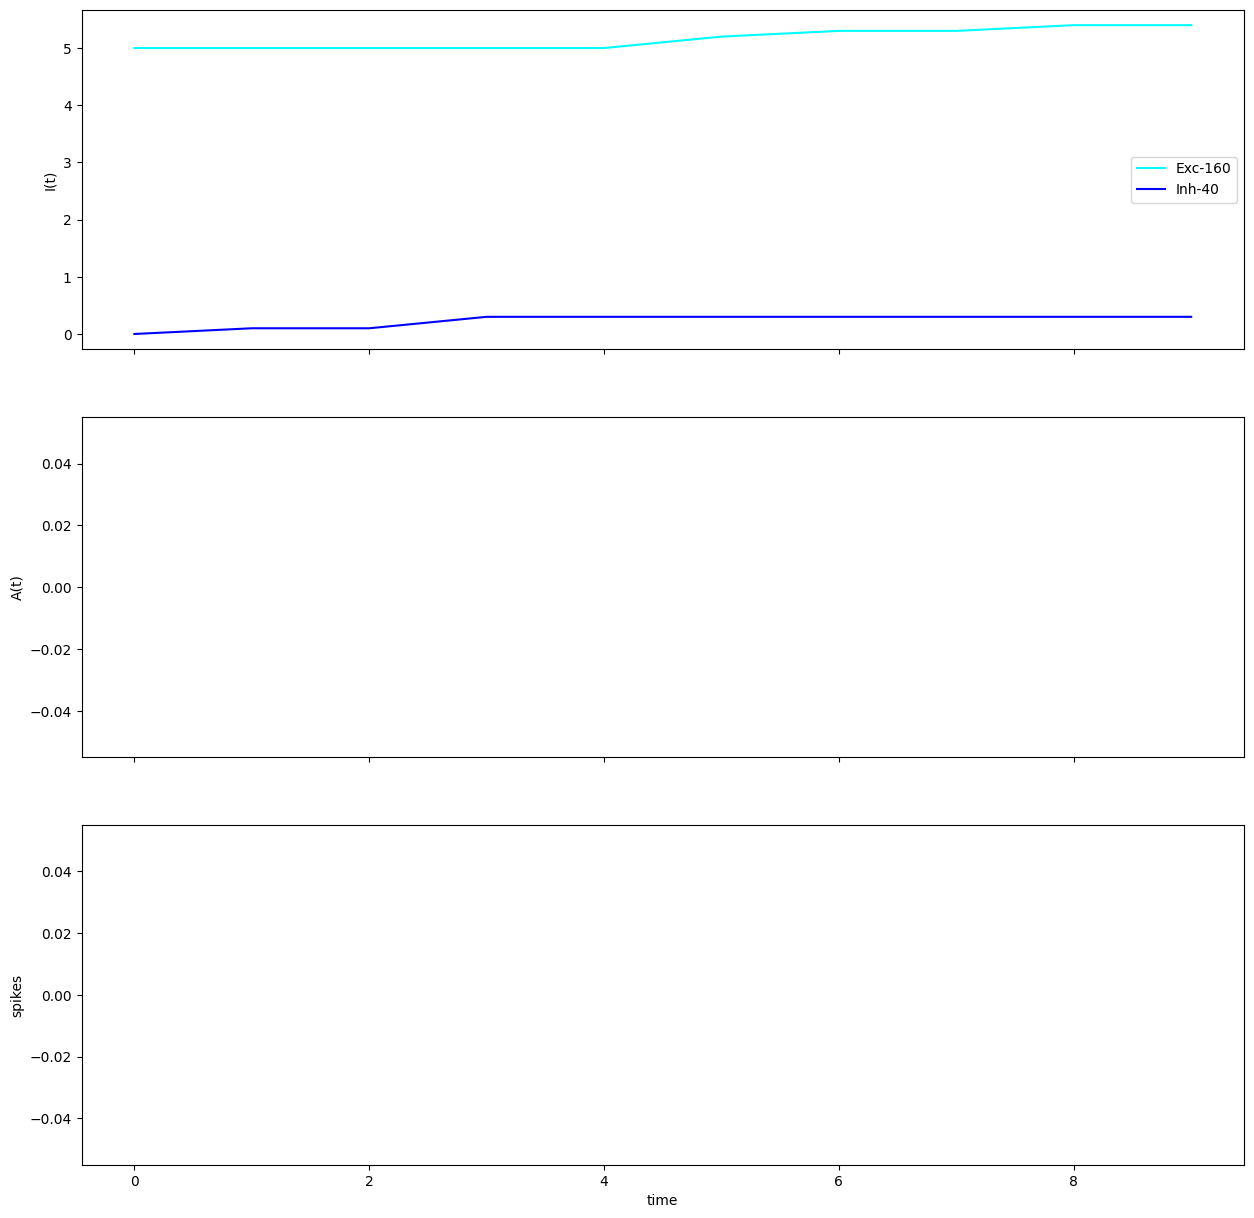

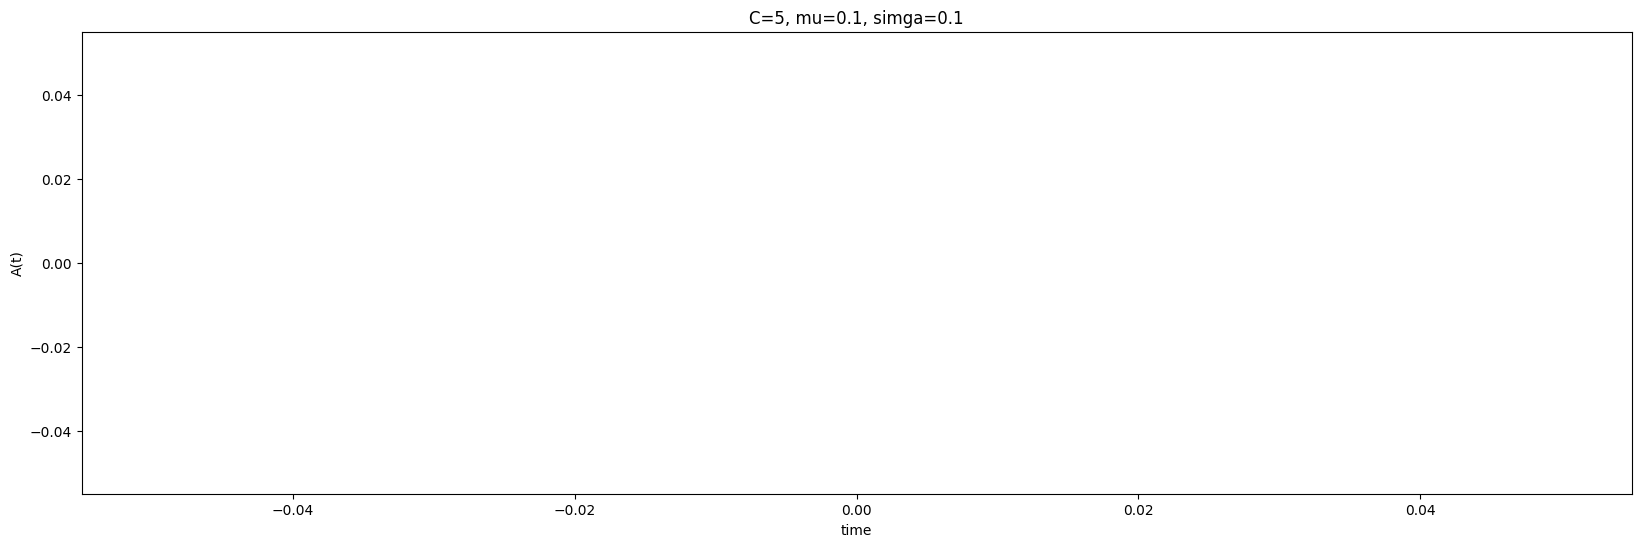

In [23]:
N = 200
p = 0.8
net = Network(behavior={1: TimeResolution(dt=1)})
ng1 = NeuronGroup(net=net,
                  size=round(N*p),
                  behavior={2: NoiseCurrent(value=5, limit=0.1, rate=0.5), 
                            4: DendriteDirac(),
                            5: LIF(R=5, 
                                        threshold=-50, 
                                        u_rest=-70, 
                                        u_reset=-70,  
                                        tau=10), 
                            7: Recorder(tag='ng1_rec', variables=['u', 'I']), 
                            8: EventRecorder(tag='ng1_eventrec', variables=['spike'])})

ng2 = NeuronGroup(net=net,
                  size=round(N*(1-p)),
                  behavior={2: NoiseCurrent(value=0, limit=0.1, rate=0.5), 
                            4: DendriteDirac(),
                            5: LIF(R=5, 
                                        threshold=-50, 
                                        u_rest=-70, 
                                        u_reset=-70,  
                                        tau=10), 
                            7: Recorder(tag='ng2_rec', variables=['u', 'I']), 
                            8: EventRecorder(tag='ng2_eventrec', variables=['spike'])})


# SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFunc(mu=0.1, sigma=0.1, coef=1)})
# SynapseGroup(tag='inh',net=net, src=ng2, dst=ng1, behavior={3: SynFunc(mu=0.1, sigma=0.1, coef=-1)})

# SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncFull(N=N, mu=0.9, sigma=0.2, coef=1)})
# SynapseGroup(tag='inh',net=net, src=ng2, dst=ng1, behavior={3: SynFuncFull(N=N, mu=0.6, sigma=0.2, coef=-1)})

# SynapseGroup(tag='exc',net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFCP(N=N, p=0.4, J=0.4, coef=1)})
# SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFCP(N=N,  p=0.4, J=0.4, coef=-1)})

SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFNPP(N=N, C=2, mu=0.1, sigma=0.1, coef=1)})
SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFNPP(N=N, C=2, mu=0.1, sigma=0.11, coef=-1)})


net.initialize()
net.simulate_iterations(10)
# C2,5,2-5,5-2
# mu
fig, axs = plt.subplots(3, sharex=True, figsize=(15, 15))
axs[0].plot(net['ng1_rec', 0].variables['I'][:,:1], color='cyan', label=f'Exc-{ng1.size}')
axs[0].plot(net['ng2_rec', 0].variables['I'][:,:1], color='blue', label=f'Inh-{ng2.size}')
axs[0].set_ylabel("I(t)")
axs[0].legend()


unique_times1, counts1= torch.unique(net['ng1_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
unique_times2, counts2= torch.unique(net['ng2_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
axs[1].plot(unique_times1, counts1/ng1.size, color='cyan')
axs[1].plot(unique_times2, counts2/ng2.size, color='blue')
axs[1].set_ylabel("A(t)")

axs[2].scatter(net['ng1_eventrec', 0].variables['spike'][:, 0], net['ng1_eventrec', 0].variables['spike'][:, 1] + ng2.size, color='cyan', s=10)
axs[2].scatter(net['ng2_eventrec', 0].variables['spike'][:, 0], net['ng2_eventrec', 0].variables['spike'][:, 1], color='blue', s=10)
axs[2].set_xlabel("time")
axs[2].set_ylabel("spikes")

plt.figure(figsize=(20, 6))
unique_times1, counts1= torch.unique(net['ng1_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
unique_times2, counts2= torch.unique(net['ng2_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
plt.plot(unique_times1, counts1/ng1.size, color='cyan')
plt.plot(unique_times2, counts2/ng2.size, color='blue')
plt.ylabel("A(t)")
plt.xlabel("time")
plt.title('C=5, mu=0.1, simga=0.1')
plt.show()

## decision


In [24]:
import matplotlib.image as mpimg

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(60, 40), dpi=200, gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True)
axs[0][0].imshow(mpimg.imread('/Users/macbook/Desktop/Decision/c2m0.1.png'))
axs[0][0].set_title('A) C=2, mu=0.1, sigma=0.1')
axs[0][1].imshow(mpimg.imread('/Users/macbook/Desktop/Decision/c2m0.2.png'))
axs[0][1].set_title('B) C=2, mu=0.2, sigma=0.1')
axs[0][2].imshow(mpimg.imread('/Users/macbook/Desktop/Decision/c2m0.2-0.1.png'))
axs[0][2].set_title('C) C=2, mu_E=0.2, mu_I=0.1')
axs[0][3].imshow(mpimg.imread('/Users/macbook/Desktop/Decision/c2m0.1-0.2.png'))
axs[0][3].set_title('D) C=2, mu_E=0.1, mu_I=0.2')

axs[1][0].imshow(mpimg.imread('/Users/macbook/Desktop/Decision/xc2m0.1.png'))
axs[1][0].set_title('E) C=2, mu=0.1, sigma=0.1')
axs[1][1].imshow(mpimg.imread('/Users/macbook/Desktop/Decision/xc2m0.2.png'))
axs[1][1].set_title('F) C=2, mu=0.2, sigma=0.1')
axs[1][2].imshow(mpimg.imread('/Users/macbook/Desktop/Decision/xc2m0.2-0.1.png'))
axs[1][2].set_title('G) C=2, mu_E=0.2, mu_I=0.1')
axs[1][3].imshow(mpimg.imread('/Users/macbook/Desktop/Decision/xc2m0.1-0.2.png'))
axs[1][3].set_title('H) C=2, mu_E=0.1, mu_I=0.2')

for i in range(2):
    for j in range(4):
        axs[i][j].axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/macbook/Desktop/Decision/c2m0.1.png'

Network['Network'](Neurons: tensor(300)|3 groups, Synapses: tensor(60000)|6 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){2:NoiseCurrent(value=9,limit=0.1,rate=0.9,)4:DendriteDirac()5:LIF(R=5,threshold=-50,u_rest=-70,u_reset=-70,tau=10,)7:Recorder(variables=['u', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)8:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_eventrec,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](100){2:NoiseCurrent(value=0,limit=0.1,rate=0.9,)4:DendriteDirac()5:LIF(R=5,threshold=-50,u_rest=-70,u_reset=-70,tau=10,)7:Recorder(variables=['u', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)8:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_eventrec,)}
NeuronGroup['NeuronGroup_3', 'NeuronGroup', 'ng'](100){2:NoiseCurrent(value=5,limit=0.1,rate=0.9,)4:DendriteDirac()5:LIF(R=5,threshold=-50,u_rest=-70,u_reset=-70

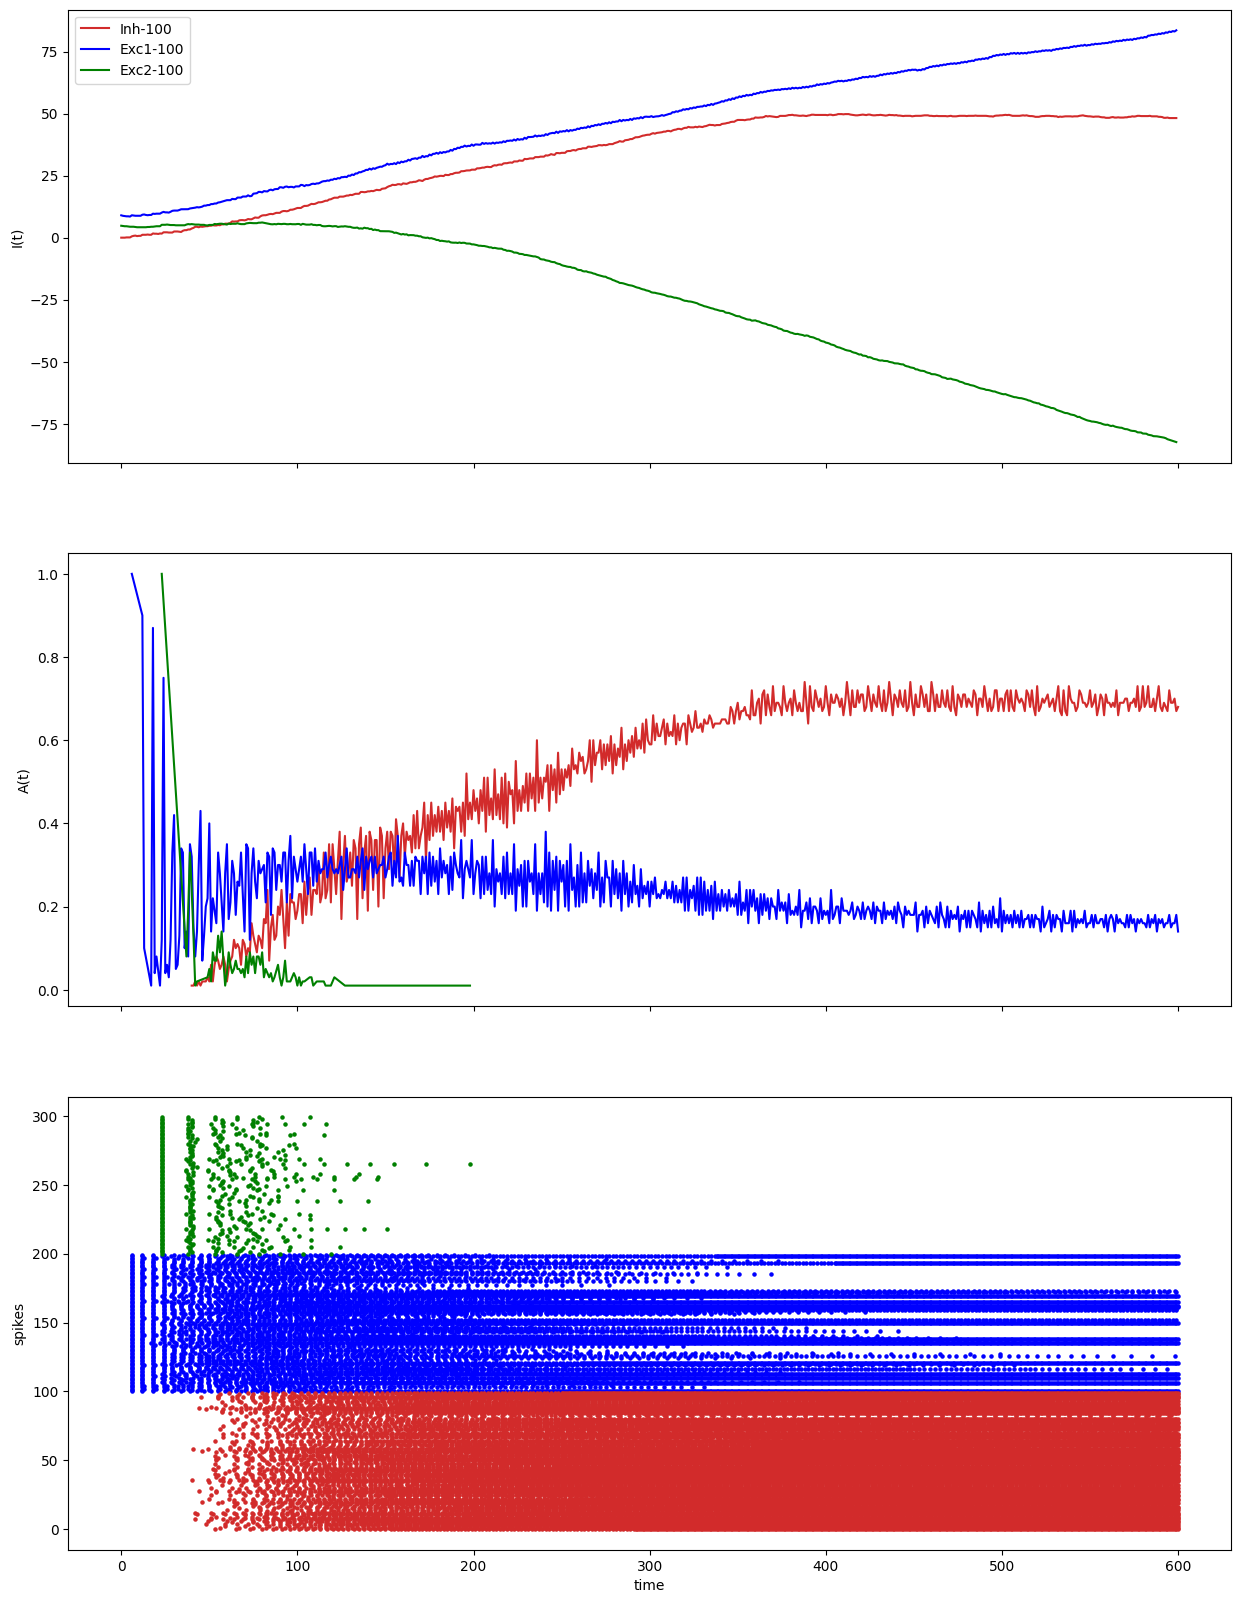

In [ ]:
N = 100
p = 1
net = Network(behavior={1: TimeResolution(dt=1)})
ng1 = NeuronGroup(net=net,
                  size=100,
                  behavior={2: NoiseCurrent(value=9, limit=0.1, rate=0.9), 
                            4: DendriteDirac(),
                            5: LIF(R=5, 
                                        threshold=-50, 
                                        u_rest=-70, 
                                        u_reset=-70,  
                                        tau=10), 
                            7: Recorder(tag='ng1_rec', variables=['u', 'I']), 
                            8: EventRecorder(tag='ng1_eventrec', variables=['spike'])})

ng2 = NeuronGroup(net=net,
                  size=100,
                  behavior={2: NoiseCurrent(value=0, limit=0.1, rate=0.9), 
                         4: DendriteDirac(),
                            5: LIF(R=5, 
                                        threshold=-50, 
                                        u_rest=-70, 
                                        u_reset=-70,  
                                        tau=10), 
                            7: Recorder(tag='ng2_rec', variables=['u', 'I']), 
                            8: EventRecorder(tag='ng2_eventrec', variables=['spike'])})

ng3 = NeuronGroup(net=net,
                  size=100,
                  behavior={2: NoiseCurrent(value=5, limit=0.1, rate=0.9), 
                            4: DendriteDirac(),
                            5: LIF(R=5, 
                                        threshold=-50, 
                                        u_rest=-70, 
                                        u_reset=-70,  
                                        tau=10), 
                            7: Recorder(tag='ng3_rec', variables=['u', 'I']), 
                            8: EventRecorder(tag='ng3_eventrec', variables=['spike'])})

def runSyn():
    SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFunc(mu=0.1, sigma=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFunc(mu=0.1, sigma=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFunc(mu=0.1, sigma=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFunc(mu=0.1, sigma=0.1, coef=1)})
    SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFunc(mu=0.01, sigma=0.01, coef=-1)})
    SynapseGroup(tag='inh', net=net, src=ng2, dst=ng3, behavior={3: SynFunc(mu=0.01, sigma=0.01, coef=-1)})

def runSynFull():
    SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFuncFull(N=ng1.size,             mu=0.3, sigma=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncFull(N=ng1.size + ng2.size,  mu=0.3, sigma=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFuncFull(N=ng3.size,             mu=0.3, sigma=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFuncFull(N=ng3.size + ng2.size,  mu=0.3, sigma=0.1, coef=1)})
    SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFuncFull(N=ng1.size + ng2.size,  mu=0.2, sigma=0.1, coef=-1)})
    SynapseGroup(tag='inh', net=net, src=ng2, dst=ng3, behavior={3: SynFuncFull(N=ng3.size + ng2.size,  mu=0.2, sigma=0.1, coef=-1)})

def runSynFCP():
    SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFuncRandFCP(N=ng1.size,              p=0.1, J=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFCP(N=ng1.size + ng2.size,   p=0.1, J=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFuncRandFCP(N=ng3.size,              p=0.1, J=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFuncRandFCP(N=ng3.size + ng2.size,   p=0.1, J=0.1, coef=1)})
    SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFCP(N=ng1.size + ng2.size,   p=0.1, J=0.1, coef=-1)})
    SynapseGroup(tag='inh', net=net, src=ng2, dst=ng3, behavior={3: SynFuncRandFCP(N=ng2.size + ng2.size,   p=0.1, J=0.1, coef=-1)})

def runSynFNPP():
    SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFuncRandFNPP(C=2, mu=0.2, sigma=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFNPP(C=2, mu=0.2, sigma=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFuncRandFNPP(C=2, mu=0.2, sigma=0.1, coef=1)})
    SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFuncRandFNPP(C=2, mu=0.2, sigma=0.1, coef=1)})
    SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFNPP(C=2, mu=0.2, sigma=0.1, coef=-1)})
    SynapseGroup(tag='inh', net=net, src=ng2, dst=ng3, behavior={3: SynFuncRandFNPP(C=2, mu=0.2, sigma=0.1, coef=-1)})

def drawMPD(name, clr):
    xx = net[name, 0].variables['u']
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))  # Adjust figsize as needed

    axx = 0
    axy = 0

    len9 = int(len(xx)/9)
    # Calculate min and max to cover all data points
    for i in range(len9, len(xx), len9):
        bin_min = np.floor(xx[i].min())
        bin_max = np.ceil(xx[i].max()) + 1
        bins = np.arange(bin_min, bin_max, 1)
        
        axs[axx, axy].hist(xx[i], bins=bins, color=clr) 
        axs[axx, axy].set_xlabel('Membrane Potential')
        axs[axx, axy].set_ylabel('Frequency')
        axs[axx, axy].set_title(f'MPD (epoch {i})')
        axy += 1
        if axy == 3:
            axx += 1
            axy = 0
        if axx == 3:
            break
    plt.show()

def drawshits():
    fig, axs = plt.subplots(3, sharex=True, figsize=(15, 20))
    ng1_color = 'blue'
    ng2_color = '#D22B2B'
    ng3_color = 'green'

    axs[0].plot(net['ng2_rec', 0].variables['I'][:,:1], color=ng2_color, label=f'Inh-{ng2.size}')
    axs[0].plot(net['ng1_rec', 0].variables['I'][:,:1], color=ng1_color, label=f'Exc1-{ng1.size}')
    axs[0].plot(net['ng3_rec', 0].variables['I'][:,:1], color=ng3_color,label=f'Exc2-{ng3.size}')
    axs[0].legend()
    axs[0].set_ylabel("I(t)")

    unique_times1, counts1= torch.unique(net['ng1_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
    unique_times2, counts2= torch.unique(net['ng2_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
    unique_times3, counts3= torch.unique(net['ng3_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
    axs[1].plot(unique_times2, counts2/ng2.size, color=ng2_color)
    axs[1].plot(unique_times1, counts1/ng1.size, color=ng1_color)
    axs[1].plot(unique_times3, counts3/ng3.size, color=ng3_color)
    axs[1].set_ylabel("A(t)")

    axs[2].scatter(net['ng1_eventrec', 0].variables['spike'][:, 0], net['ng1_eventrec', 0].variables['spike'][:, 1] + ng2.size, color=ng1_color, s=5)
    axs[2].scatter(net['ng2_eventrec', 0].variables['spike'][:, 0], net['ng2_eventrec', 0].variables['spike'][:, 1], color=ng2_color, s=5)
    axs[2].scatter(net['ng3_eventrec', 0].variables['spike'][:, 0], net['ng3_eventrec', 0].variables['spike'][:, 1] + ng1.size + ng2.size, color=ng3_color, s=5)
    axs[2].set_xlabel("time")
    axs[2].set_ylabel("spikes")
    plt.show()

runSynFNPP()
net.initialize()
net.simulate_iterations(600)
drawshits()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/macbook/Desktop/NEW/147.png'

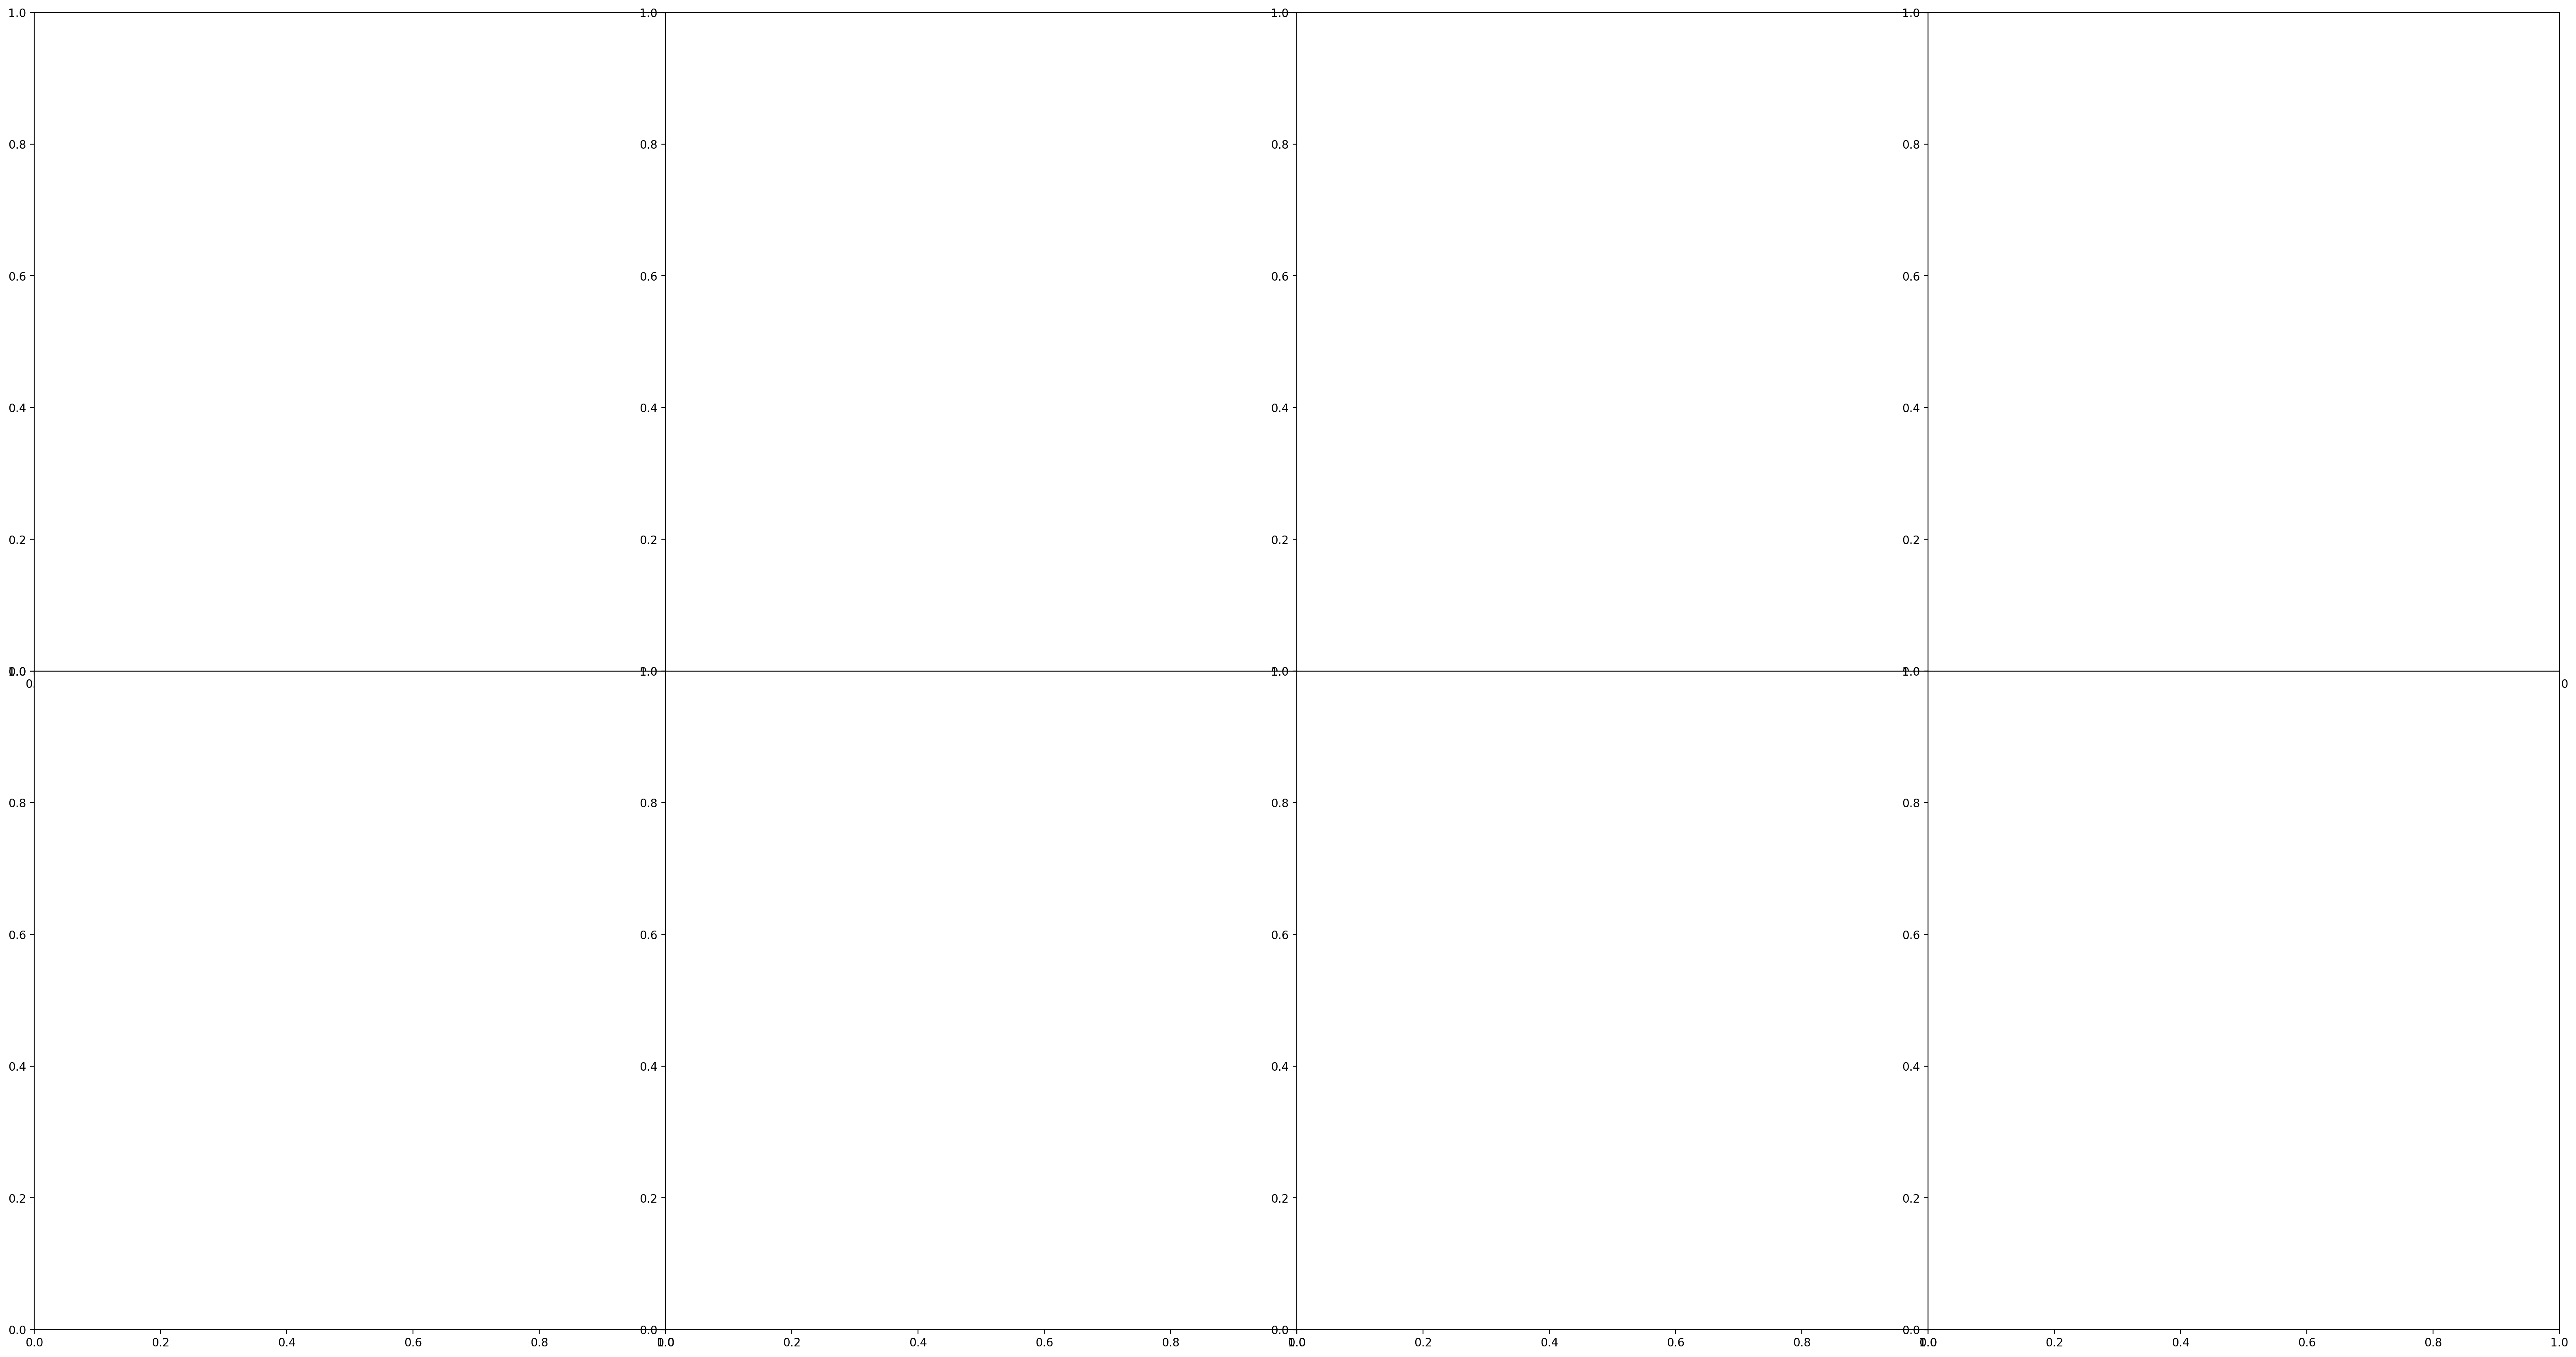

In [ ]:
import matplotlib.image as mpimg

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(40, 21), dpi=200, gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True)
axs[0, 0].imshow(mpimg.imread('/Users/macbook/Desktop/NEW/147.png'))
axs[0, 0].set_title('A) p=0.1, J_E=0.4, J_I=0.7')
axs[0, 1].imshow(mpimg.imread('/Users/macbook/Desktop/NEW/447.png'))
axs[0, 1].set_title('B) p=0.4, J_E=0.4, J_I=0.7')
axs[0, 2].imshow(mpimg.imread('/Users/macbook/Desktop/NEW/174.png'))
axs[0, 2].set_title('C) p=0.1, J_E=0.7, J_I=0.4')
axs[0, 3].imshow(mpimg.imread('/Users/macbook/Desktop/NEW/474.png'))
axs[0, 3].set_title('D) p=0.4, J_E=0.7, J_I=0.4')

axs[1, 0].imshow(mpimg.imread('/Users/macbook/Desktop/NEW/14.png'))
axs[1, 0].set_title('E) p=0.1, J=0.4')
axs[1, 1].imshow(mpimg.imread('/Users/macbook/Desktop/NEW/44.png'))
axs[1, 1].set_title('F) p=0.4, J=0.4')
axs[1, 2].imshow(mpimg.imread('/Users/macbook/Desktop/NEW/17.png'))
axs[1, 2].set_title('G) p=0.1, J=0.7')
axs[1, 3].imshow(mpimg.imread('/Users/macbook/Desktop/NEW/47.png'))
axs[1, 3].set_title('H) p=0.4, J=0.7')


for i in range(2):
    for j in range(4):
        axs[i, j].axis('off')
plt.show()

In [ ]:
import matplotlib.image as mpimg

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(40, 21), dpi=200, gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True)
axs[0, 0].imshow(mpimg.imread('/Users/macbook/Desktop/c2m0.05.png'))
axs[0, 0].set_title('A) C=2, mu=0.05, sigma=0.01')
axs[0, 1].imshow(mpimg.imread('/Users/macbook/Desktop/FNPP/fnpp200c5m0.05s0.01.png'))
axs[0, 1].set_title('B) C=5, mu=0.05, sigma=0.01')
axs[0, 2].imshow(mpimg.imread('/Users/macbook/Desktop/FNPP/fnpp200c2-5m0.05s0.01.png'))
axs[0, 2].set_title('C) C_E=2, C_I=5, mu=0.05, sigma=0.01')
axs[0, 3].imshow(mpimg.imread('/Users/macbook/Desktop/FNPP/fnpp200c5-2m0.05s0.01.png'))
axs[0, 3].set_title('D) C_E=5, C_I=2, mu=0.05, sigma=0.01')


axs[1, 0].imshow(mpimg.imread('/Users/macbook/Desktop/c2m0.09.png'))
axs[1, 0].set_title('E) C=2, mu=0.09, sigma=0.01')
axs[1, 1].imshow(mpimg.imread('/Users/macbook/Desktop/c2m0.1.png'))
axs[1, 1].set_title('F) C=2, mu=0.1, sigma=0.1', )
axs[1, 2].imshow(mpimg.imread('/Users/macbook/Desktop/c2m0.09-0.05.png'))
axs[1, 2].set_title('G) C=2, mu_E=0.09, mu_I=0.05, sigma=0.01')
axs[1, 3].imshow(mpimg.imread('/Users/macbook/Desktop/c2m0.05-0.9.png'))
axs[1, 3].set_title('H) C=2, mu_E=0.05, mu_I=0.09, sigma=0.01')


for i in range(2):
    for j in range(4):
        axs[i, j].axis('off')
plt.show()

In [ ]:
import matplotlib.image as mpimg

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(40, 21), dpi=200, gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True)
axs[0, 0].imshow(mpimg.imread('/Users/macbook/Desktop/FNPP/fnpp200c2-5m0.05s0.01.png'))
axs[0, 0].set_title('A) C_E=2, C_I=5, mu=0.05, sigma=0.01')
axs[0, 1].imshow(mpimg.imread('/Users/macbook/Desktop/FNPP/fnpp400c2-5m0.05s0.01.png'))
axs[0, 1].set_title('B) C_E=2, C_I=5, mu=0.05, sigma=0.01')
axs[0, 2].imshow(mpimg.imread('/Users/macbook/Desktop/FNPP/fnpp200c5-2m0.05s0.01.png'))
axs[0, 2].set_title('C) C_E=5, C_I=2, mu=0.05, sigma=0.01')
axs[0, 3].imshow(mpimg.imread('/Users/macbook/Desktop/FNPP/fnpp400c5-2m0.05s0.01.png'))
axs[0, 3].set_title('D) C_E=5, C_I=2, mu=0.05, sigma=0.01')

axs[1, 0].imshow(mpimg.imread('/Users/macbook/Desktop/FNPP/fnpp200c5m0.1-0.8s0.1.png'))
axs[1, 0].set_title('E) C=5, mu_E=0.1, mu_I=0.8, sigma=0.1')
axs[1, 1].imshow(mpimg.imread('/Users/macbook/Desktop/FNPP/fnpp400c5m0.1-0.8s0.1.png'))
axs[1, 1].set_title('F) C=5, mu_E=0.1, mu_I=0.8, sigma=0.1', )
axs[1, 2].imshow(mpimg.imread('/Users/macbook/Desktop/FNPP/fnpp200c5m0.8-0.1s0.1.png'))
axs[1, 2].set_title('G) C=5, mu_E=0.8, mu_I=0.1, sigma=0.1')
axs[1, 3].imshow(mpimg.imread('/Users/macbook/Desktop/FNPP/fnpp400c5m0.8-0.1s0.1.png'))
axs[1, 3].set_title('H) C=5, mu_E=0.8, mu_I=0.1, sigma=0.1')


for i in range(2):
    for j in range(4):
        axs[i, j].axis('off')
plt.show()

In [ ]:
import matplotlib.image as mpimg

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(40, 21), dpi=200, gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True)
axs[0, 0].imshow(mpimg.imread('/Users/macbook/Desktop/FULL/full200m0.4-0.9s0.1.png'))
axs[0, 0].set_title('A) mu_E=0.4, mu_I=0.9, sigma=0.1')
axs[0, 1].imshow(mpimg.imread('/Users/macbook/Desktop/FULL/full400m0.4-0.9s0.1.png'))
axs[0, 1].set_title('B) mu_E=0.4, mu_I=0.9, sigma=0.1')
axs[0, 2].imshow(mpimg.imread('/Users/macbook/Desktop/FULL/full200m0.9-0.4s0.1.png'))
axs[0, 2].set_title('C) mu_E=0.9, mu_I=0.4, sigma=0.1')
axs[0, 3].imshow(mpimg.imread('/Users/macbook/Desktop/FULL/full400m0.9-0.4s0.1.png'))
axs[0, 3].set_title('D) mu_E=0.9, mu_I=0.4, sigma=0.1')

axs[1, 0].imshow(mpimg.imread('/Users/macbook/Desktop/FULL/full200m0.6-0.9s0.1.png'))
axs[1, 0].set_title('E) mu_E=0.6, mu_I=0.9, sigma=0.1')
axs[1, 1].imshow(mpimg.imread('/Users/macbook/Desktop/FULL/full400m0.6-0.9s0.1.png'))
axs[1, 1].set_title('F) mu_E=0.6, mu_I=0.9, sigma=0.1')
axs[1, 2].imshow(mpimg.imread('/Users/macbook/Desktop/FULL/full200m0.9-0.6s0.1.png'))
axs[1, 2].set_title('G) mu_E=0.9, mu_I=0.6, sigma=0.1')
axs[1, 3].imshow(mpimg.imread('/Users/macbook/Desktop/FULL/full400m0.9-0.6s0.1.png'))
axs[1, 3].set_title('H) mu_E=0.9, mu_I=0.6, sigma=0.1')


for i in range(2):
    for j in range(4):
        axs[i, j].axis('off')
plt.show()

In [ ]:
# N = 200
# p = 1
# net = Network(behavior={1: TimeResolution(dt=1)})
# ng1 = NeuronGroup(net=net,
#                   size=round(N*(p/2)),
#                   behavior={2: NoiseCurrent(value=3, limit=0.1, rate=0.9), 
#                             4: DendriteDirac(),
#                             5: LIF(R=5, 
#                                         threshold=-50, 
#                                         u_rest=-65, 
#                                         u_reset=-70,  
#                                         tau=10), 
#                             7: Recorder(tag='ng1_rec', variables=['u', 'I']), 
#                             8: EventRecorder(tag='ng1_eventrec', variables=['spike'])})

# ng2 = NeuronGroup(net=net,
#                   size=round(N*(1-p)),
#                   behavior={2: NoiseCurrent(value=0, limit=0.1, rate=0.9), 
#                          4: DendriteDirac(),
#                             5: LIF(R=5, 
#                                         threshold=-50, 
#                                         u_rest=-65, 
#                                         u_reset=-70,  
#                                         tau=10), 
#                             7: Recorder(tag='ng2_rec', variables=['u', 'I']), 
#                             8: EventRecorder(tag='ng2_eventrec', variables=['spike'])})

# ng3 = NeuronGroup(net=net,
#                   size=round(N*(p/2)),
#                   behavior={2: NoiseCurrent(value=7, limit=0.1, rate=0.9), 
#                             4: DendriteDirac(),
#                             5: LIF(R=5, 
#                                         threshold=-50, 
#                                         u_rest=-65, 
#                                         u_reset=-70,  
#                                         tau=10), 
#                             7: Recorder(tag='ng3_rec', variables=['u', 'I']), 
#                             8: EventRecorder(tag='ng3_eventrec', variables=['spike'])})

# def runSyn():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFunc(mu=0.2, sigma=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFunc(mu=0.2, sigma=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFunc(mu=0.2, sigma=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFunc(mu=0.2, sigma=0.1, coef=1)})
#     SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFunc(mu=0.2, sigma=0.1, coef=-1)})
#     SynapseGroup(tag='inh', net=net, src=ng2, dst=ng3, behavior={3: SynFunc(mu=0.2, sigma=0.1, coef=-1)})

# def runSynFull():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFuncFull(N=ng1.size,             mu=0.2, sigma=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncFull(N=ng1.size + ng2.size,  mu=0.2, sigma=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFuncFull(N=ng3.size,             mu=0.2, sigma=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFuncFull(N=ng3.size + ng2.size,  mu=0.2, sigma=0.1, coef=1)})
#     SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFuncFull(N=ng1.size + ng2.size,   mu=0.4, sigma=0.1, coef=-1)})
#     SynapseGroup(tag='inh', net=net, src=ng2, dst=ng3, behavior={3: SynFuncFull(N=ng3.size + ng2.size,   mu=0.4, sigma=0.1, coef=-1)})

# def runSynFCP():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFuncRandFCP(N=ng1.size, p=0.1, J=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFCP(N=ng1.size, p=0.1, J=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFuncRandFCP(N=ng3.size, p=0.1, J=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFuncRandFCP(N=ng3.size, p=0.1, J=0.1, coef=1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFCP(N=ng2.size, p=0.1, J=0.1, coef=-1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng3, behavior={3: SynFuncRandFCP(N=ng4.size, p=0.1, J=0.1, coef=-1)})

# def runSynFNPP():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFNPP(N=ng1.size, C=5, mu=0.01, sigma=0.1, coef=1)})
#     SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFNPP(N=ng2.size, C=5, mu=0.01, sigma=0.1, coef=-1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng4, behavior={3: SynFuncRandFNPP(N=ng3.size, C=5, mu=0.01, sigma=0.1, coef=1)})
#     SynapseGroup(tag='inh', net=net, src=ng4, dst=ng3, behavior={3: SynFuncRandFNPP(N=ng4.size, C=5, mu=0.01, sigma=0.1, coef=-1)})

# def drawshits():
#     fig, axs = plt.subplots(4, sharex=True, figsize=(15, 20))

#     axs[0].plot(net['ng1_rec', 0].variables['I'][:,:1], color='red', label=f'Exc1-{ng1.size}')
#     axs[0].plot(net['ng2_rec', 0].variables['I'][:,:1], color='blue', label=f'Inh-{ng2.size}')
#     axs[0].plot(net['ng3_rec', 0].variables['I'][:,:1], color='green',label=f'Exc2-{ng3.size}')
#     axs[0].legend()
#     axs[0].set_ylabel("I(t)")

#     mean_u_per_it1 = torch.mean(net['ng1_rec', 0].variables['u'], dim=1)
#     mean_u_per_it2 = torch.mean(net['ng2_rec', 0].variables['u'], dim=1)
#     mean_u_per_it2 = torch.mean(net['ng3_rec', 0].variables['u'], dim=1)
#     axs[1].plot(mean_u_per_it1, color='red')
#     axs[1].plot(mean_u_per_it2, color='blue')
#     axs[1].plot(mean_u_per_it2, color='green')
#     axs[1].set_ylabel("Avg u(t)")

#     unique_times1, counts1= torch.unique(net['ng1_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
#     unique_times2, counts2= torch.unique(net['ng2_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
#     unique_times3, counts3= torch.unique(net['ng3_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
#     axs[2].plot(unique_times1, counts1/ng1.size, color='red')
#     axs[2].plot(unique_times2, counts2/ng2.size, color='blue')
#     axs[2].plot(unique_times3, counts3/ng3.size, color='green')
#     axs[2].set_ylabel("A(t)")

#     axs[3].scatter(net['ng1_eventrec', 0].variables['spike'][:, 0], net['ng1_eventrec', 0].variables['spike'][:, 1] + ng2.size, color='red')
#     axs[3].scatter(net['ng2_eventrec', 0].variables['spike'][:, 0], net['ng2_eventrec', 0].variables['spike'][:, 1], color='blue')
#     axs[3].scatter(net['ng3_eventrec', 0].variables['spike'][:, 0], net['ng3_eventrec', 0].variables['spike'][:, 1] + ng1.size + ng2.size, color='green')
#     axs[3].set_xlabel("time")
#     axs[3].set_ylabel("spikes")

#     plt.show()

# runSynFCP()
# net.initialize()
# net.simulate_iterations(100)
# drawshits()
# # drawPlots(net, ng1, 'ng1_rec', 'ng1_eventrec')
# # drawPlots(net, ng2, 'ng2_rec', 'ng2_eventrec')
# # drawPlots(net, ng3, 'ng3_rec', 'ng3_eventrec')

In [ ]:
# net = Network(behavior={1: TimeResolution(dt=1)})
# ng1 = NeuronGroup(net=net,
#                   size=40,
#                   behavior={2: NoiseCurrent(value=2, limit=0.1, rate=1), 
#                             4: DendriteDirac(),
#                             5: LIF(R=5, 
#                                         threshold=-55, 
#                                         u_rest=-65, 
#                                         u_reset=-70,  
#                                         tau=8), 
#                             7: Recorder(tag='ng1_rec', variables=['u', 'I']), 
#                             8: EventRecorder(tag='ng1_eventrec', variables=['spike'])})

# ng2 = NeuronGroup(net=net,
#                   size=20,
#                   behavior={2:NoiseCurrent(value=0, limit=0.1, rate=1), 
#                             4: DendriteDirac(),
#                             5: LIF(R=5, 
#                                         threshold=-55, 
#                                         u_rest=-65, 
#                                         u_reset=-70,  
#                                         tau=8), 
#                             7: Recorder(tag='ng2_rec', variables=['u', 'I']), 
#                             8: EventRecorder(tag='ng2_eventrec', variables=['spike'])})

# ng3 = NeuronGroup(net=net,
#                   size=40,
#                   behavior={2: NoiseCurrent(value=7, limit=0.1, rate=1), 
#                             4: DendriteDirac(),
#                             5: LIF(R=5, 
#                                         threshold=-55, 
#                                         u_rest=-65, 
#                                         u_reset=-70,  
#                                         tau=8), 
#                             7: Recorder(tag='ng3_rec', variables=['u', 'I']), 
#                             8: EventRecorder(tag='ng3_eventrec', variables=['spike'])})

# def runSyn():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng1, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=-1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng3, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=-1)})

# def runSynFull():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFuncFull(N=ng1.size, mu=0.02, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncFull(N=ng1.size, mu=0.01, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFuncFull(N=ng3.size, mu=0.02, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFuncFull(N=ng3.size, mu=0.01, sigma=0.01, coef=1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng1, behavior={3: SynFuncFull(N=ng2.size, mu=0.04, sigma=0.01, coef=-1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng3, behavior={3: SynFuncFull(N=ng2.size, mu=0.04, sigma=0.01, coef=-1)})

# def runSynFCP():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFuncRandFCP(N=ng1.size, p=0.1, J=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFCP(N=ng1.size, p=0.1, J=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFuncRandFCP(N=ng3.size, p=0.1, J=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFuncRandFCP(N=ng3.size, p=0.1, J=0.1, coef=1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFCP(N=ng2.size, p=0.1, J=0.1, coef=-1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng3, behavior={3: SynFuncRandFCP(N=ng4.size, p=0.1, J=0.1, coef=-1)})

# def runSynFNPP():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFNPP(N=ng1.size, C=5, mu=0.01, sigma=0.1, coef=1)})
#     SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFNPP(N=ng2.size, C=5, mu=0.01, sigma=0.1, coef=-1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng4, behavior={3: SynFuncRandFNPP(N=ng3.size, C=5, mu=0.01, sigma=0.1, coef=1)})
#     SynapseGroup(tag='inh', net=net, src=ng4, dst=ng3, behavior={3: SynFuncRandFNPP(N=ng4.size, C=5, mu=0.01, sigma=0.1, coef=-1)})

# def drawshits():
#     fig, axs = plt.subplots(3, sharex=True, figsize=(15, 20))

#     axs[0].plot(net['ng1_rec', 0].variables['I'][:,:1], color='red', label='ng1-exc')
#     axs[0].plot(net['ng2_rec', 0].variables['I'][:,:1], color='blue', label='ng2-inh')
#     axs[0].plot(net['ng3_rec', 0].variables['I'][:,:1], color='green',label='ng3-exc')
#     axs[0].legend()
#     axs[0].set_ylabel("I(t)")

#     mean_u_per_it1 = torch.mean(net['ng1_rec', 0].variables['u'], dim=1)
#     mean_u_per_it2 = torch.mean(net['ng2_rec', 0].variables['u'], dim=1)
#     mean_u_per_it2 = torch.mean(net['ng3_rec', 0].variables['u'], dim=1)
#     axs[1].plot(mean_u_per_it1, color='red')
#     axs[1].plot(mean_u_per_it2, color='blue')
#     axs[1].plot(mean_u_per_it2, color='green')
#     axs[1].set_ylabel("Avg u(t)")

#     unique_times1, counts1= torch.unique(net['ng1_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
#     unique_times2, counts2= torch.unique(net['ng2_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
#     unique_times3, counts3= torch.unique(net['ng3_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
#     axs[2].plot(unique_times1, counts1/ng1.size, color='red')
#     #axs[2].plot(unique_times2, counts2/ng2.size, color='blue')
#     axs[2].plot(unique_times3, counts3/ng3.size, color='green')
#     axs[2].set_ylabel("A(t)")
#     plt.show()


# runSynFull()
# net.initialize()
# net.simulate_iterations(500)
# drawshits()
# # drawPlots(net, ng1, 'ng1_rec', 'ng1_eventrec')
# # drawPlots(net, ng2, 'ng2_rec', 'ng2_eventrec')
# # drawPlots(net, ng3, 'ng3_rec', 'ng3_eventrec')


# plt.figure(figsize=(15,15))
# plt.scatter(net['ng1_eventrec', 0].variables['spike'][:, 0], net['ng1_eventrec', 0].variables['spike'][:, 1] + ng2.size, color='red')
# plt.scatter(net['ng2_eventrec', 0].variables['spike'][:, 0], net['ng2_eventrec', 0].variables['spike'][:, 1], color='blue')
# plt.scatter(net['ng3_eventrec', 0].variables['spike'][:, 0], net['ng3_eventrec', 0].variables['spike'][:, 1] + ng1.size + ng2.size, color='green')
# plt.xlabel("time")
# plt.ylabel("spikes")


In [ ]:
# net = Network(behavior={1: TimeResolution(dt=1)})
# ng1 = NeuronGroup(net=net,
#                   size=40,
#                   behavior={2: NoiseCurrent(value=7, limit=0.1, rate=1), 
#                             4: DendriteDirac(),
#                             5: LIF(R=5, 
#                                         threshold=-55, 
#                                         u_rest=-65, 
#                                         u_reset=-70,  
#                                         tau=8), 
#                             7: Recorder(tag='ng1_rec', variables=['u', 'I']), 
#                             8: EventRecorder(tag='ng1_eventrec', variables=['spike'])})

# ng2 = NeuronGroup(net=net,
#                   size=20,
#                   behavior={2:NoiseCurrent(value=0, limit=0.1, rate=1), 
#                             4: DendriteDirac(),
#                             5: LIF(R=5, 
#                                         threshold=-55, 
#                                         u_rest=-65, 
#                                         u_reset=-70,  
#                                         tau=8), 
#                             7: Recorder(tag='ng2_rec', variables=['u', 'I']), 
#                             8: EventRecorder(tag='ng2_eventrec', variables=['spike'])})

# ng3 = NeuronGroup(net=net,
#                   size=40,
#                   behavior={2: NoiseCurrent(value=2, limit=0.1, rate=1), 
#                             4: DendriteDirac(),
#                             5: LIF(R=5, 
#                                         threshold=-55, 
#                                         u_rest=-65, 
#                                         u_reset=-70,  
#                                         tau=8), 
#                             7: Recorder(tag='ng3_rec', variables=['u', 'I']), 
#                             8: EventRecorder(tag='ng3_eventrec', variables=['spike'])})

# def runSyn():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng1, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=-1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng3, behavior={3: SynFunc(mu=0.1, sigma=0.01, coef=-1)})

# def runSynFull():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFuncFull(N=ng1.size, mu=0.02, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncFull(N=ng1.size, mu=0.01, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFuncFull(N=ng3.size, mu=0.02, sigma=0.01, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFuncFull(N=ng3.size, mu=0.01, sigma=0.01, coef=1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng1, behavior={3: SynFuncFull(N=ng2.size, mu=0.04, sigma=0.01, coef=-1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng3, behavior={3: SynFuncFull(N=ng2.size, mu=0.04, sigma=0.01, coef=-1)})

# def runSynFCP():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng1, behavior={3: SynFuncRandFCP(N=ng1.size, p=0.1, J=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFCP(N=ng1.size, p=0.1, J=0.1, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng3, behavior={3: SynFuncRandFCP(N=ng3.size, p=0.2, J=0.2, coef=1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng2, behavior={3: SynFuncRandFCP(N=ng3.size, p=0.1, J=0.1, coef=1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFCP(N=ng2.size, p=0.1, J=0.14, coef=-1)})
#     SynapseGroup(tag='inh',net=net, src=ng2, dst=ng3, behavior={3: SynFuncRandFCP(N=ng2.size, p=0.1, J=0.14, coef=-1)})

# def runSynFNPP():
#     SynapseGroup(tag='exc', net=net, src=ng1, dst=ng2, behavior={3: SynFuncRandFNPP(N=ng1.size, C=5, mu=0.01, sigma=0.1, coef=1)})
#     SynapseGroup(tag='inh', net=net, src=ng2, dst=ng1, behavior={3: SynFuncRandFNPP(N=ng2.size, C=5, mu=0.01, sigma=0.1, coef=-1)})
#     SynapseGroup(tag='exc', net=net, src=ng3, dst=ng4, behavior={3: SynFuncRandFNPP(N=ng3.size, C=5, mu=0.01, sigma=0.1, coef=1)})
#     SynapseGroup(tag='inh', net=net, src=ng4, dst=ng3, behavior={3: SynFuncRandFNPP(N=ng4.size, C=5, mu=0.01, sigma=0.1, coef=-1)})

# def drawshits():
#     fig, axs = plt.subplots(3, sharex=True, figsize=(15, 20))

#     axs[0].plot(net['ng1_rec', 0].variables['I'][:,:1], color='red', label='ng1-exc')
#     axs[0].plot(net['ng2_rec', 0].variables['I'][:,:1], color='blue', label='ng2-inh')
#     axs[0].plot(net['ng3_rec', 0].variables['I'][:,:1], color='green',label='ng3-exc')
#     axs[0].legend()
#     axs[0].set_ylabel("I(t)")

#     mean_u_per_it1 = torch.mean(net['ng1_rec', 0].variables['u'], dim=1)
#     mean_u_per_it2 = torch.mean(net['ng2_rec', 0].variables['u'], dim=1)
#     mean_u_per_it2 = torch.mean(net['ng3_rec', 0].variables['u'], dim=1)
#     axs[1].plot(mean_u_per_it1, color='red')
#     axs[1].plot(mean_u_per_it2, color='blue')
#     axs[1].plot(mean_u_per_it2, color='green')
#     axs[1].set_ylabel("Avg u(t)")

#     unique_times1, counts1= torch.unique(net['ng1_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
#     unique_times2, counts2= torch.unique(net['ng2_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
#     unique_times3, counts3= torch.unique(net['ng3_eventrec', 0].variables['spike'][:, 0], sorted=True, return_counts=True)
#     axs[2].plot(unique_times1, counts1/ng1.size, color='red')
#     #axs[2].plot(unique_times2, counts2/ng2.size, color='blue')
#     axs[2].plot(unique_times3, counts3/ng3.size, color='green')
#     axs[2].set_ylabel("A(t)")
#     plt.show()


# runSynFCP()
# net.initialize()
# net.simulate_iterations(1000)
# drawshits()
# # drawPlots(net, ng1, 'ng1_rec', 'ng1_eventrec')
# # drawPlots(net, ng2, 'ng2_rec', 'ng2_eventrec')
# # drawPlots(net, ng3, 'ng3_rec', 'ng3_eventrec')


# plt.figure(figsize=(15,15))
# plt.scatter(net['ng1_eventrec', 0].variables['spike'][:, 0], net['ng1_eventrec', 0].variables['spike'][:, 1] + ng2.size, color='red')
# plt.scatter(net['ng2_eventrec', 0].variables['spike'][:, 0], net['ng2_eventrec', 0].variables['spike'][:, 1], color='blue')
# plt.scatter(net['ng3_eventrec', 0].variables['spike'][:, 0], net['ng3_eventrec', 0].variables['spike'][:, 1] + ng1.size + ng2.size, color='green')
# plt.xlabel("time")
# plt.ylabel("spikes")


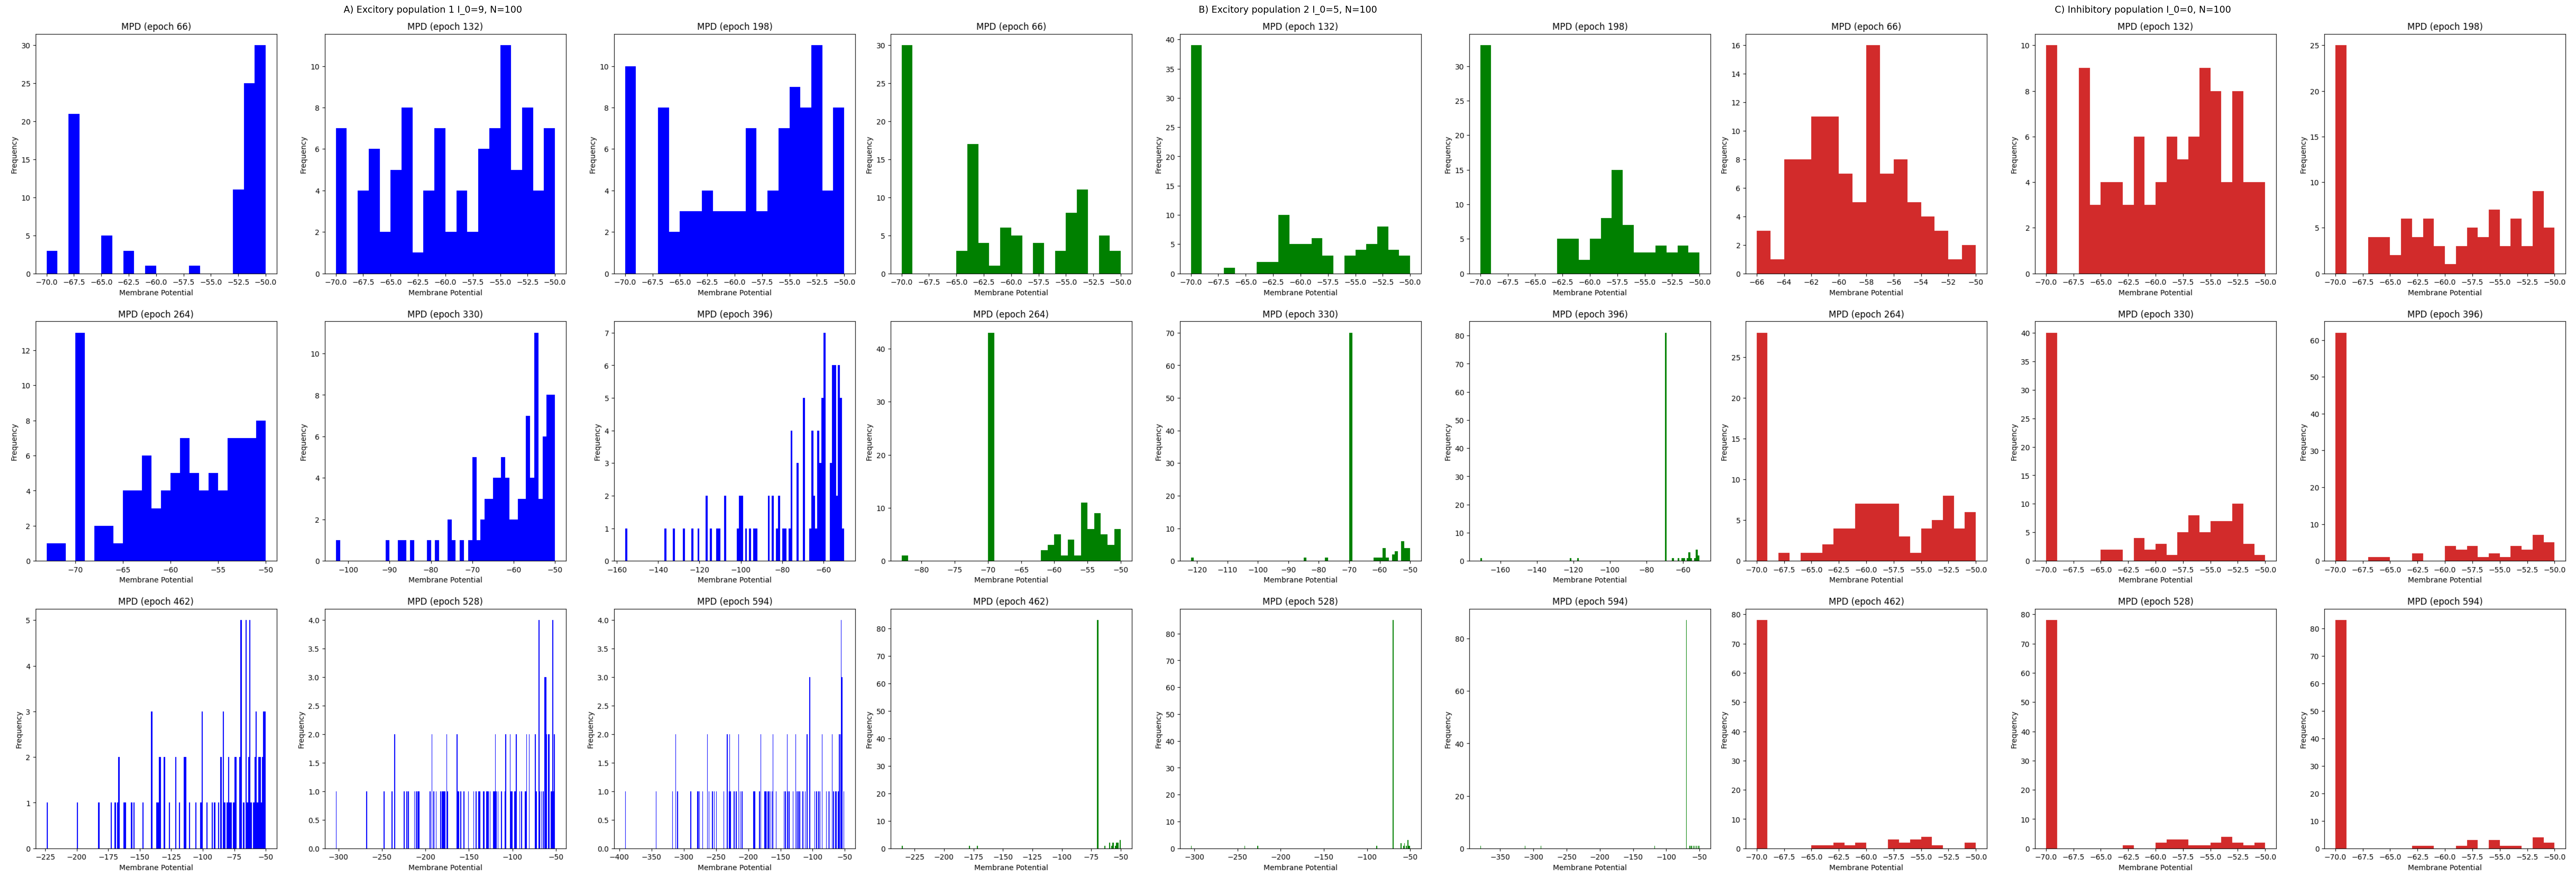

In [ ]:
import matplotlib.image as mpimg

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(60, 25), dpi=200, gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True)
axs[0].imshow(mpimg.imread('/Users/macbook/Desktop/Decision/new/greenb.png'))
axs[0].set_title('A) Excitory population 1 I_0=9, N=100')
axs[1].imshow(mpimg.imread('/Users/macbook/Desktop/Decision/new/greeng.png'))
axs[1].set_title('B) Excitory population 2 I_0=5, N=100')
axs[2].imshow(mpimg.imread('/Users/macbook/Desktop/Decision/new/greenr.png'))
axs[2].set_title('C) Inhibitory population I_0=0, N=100')



for i in range(3):
    axs[i].axis('off')
plt.show()